# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import zscore
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import warnings
import sys

if not sys.warnoptions:
    warnings.simplefilter("ignore")

sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

# Loading data

In [2]:
orders = pd.read_csv('small_orders.csv')
items = pd.read_csv('items_with_categ.csv')

In [3]:
print("Number of datapoints in orders:", len(orders))
print(orders.head())

print("\nNumber of datapoints in items:", len(items))
print(items.head())

Number of datapoints in orders: 10907
    OrderID        UserID            OrderTime  ItemID  price  quantity
0  92621976  1.602740e+18  2021-04-12 13:38:35  314615  189.9         1
1  92621976  1.602740e+18  2021-04-12 13:38:35  966349   98.9         1
2  92621976  1.602740e+18  2021-04-12 13:38:35  329633  169.9         1
3  92621976  1.602740e+18  2021-04-12 13:38:35  432058  219.0         1
4  92621976  1.602740e+18  2021-04-12 13:38:35  393166   99.9         1

Number of datapoints in items: 35030
    ItemID                 Category  ParentCategory
0  1000002  Сладости для диабетиков        Сладости
1  1000046                     Вода         Напитки
2  1000048  Сладости для диабетиков        Сладости
3  1000049                     Вода         Напитки
4  1000061                   Фрукты  Овощи и фрукты


In [4]:
print(orders.columns, items.columns, sep='\n')

Index(['OrderID', 'UserID', 'OrderTime', 'ItemID', 'price', 'quantity'], dtype='object')
Index(['ItemID', 'Category', 'ParentCategory'], dtype='object')


# Data preprocessing

### Let us have a look at the information in data.

In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10907 entries, 0 to 10906
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   OrderID    10907 non-null  int64  
 1   UserID     10907 non-null  float64
 2   OrderTime  10907 non-null  object 
 3   ItemID     10907 non-null  int64  
 4   price      10907 non-null  float64
 5   quantity   10907 non-null  int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 511.4+ KB


In [6]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35030 entries, 0 to 35029
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ItemID          35030 non-null  int64 
 1   Category        35030 non-null  object
 2   ParentCategory  35030 non-null  object
dtypes: int64(1), object(2)
memory usage: 821.1+ KB


### **From the above output, we can conclude and note that:**
- #### There are no missing values in either dataset
- #### OrderTime that indicates the date and time of each order is not parsed as DateTime
- #### There are some categotical features in the Items dataset that will need to be encoded into numeric form

In [7]:
orders.OrderTime = pd.to_datetime(orders.OrderTime)

In [8]:
# date and time related features
orders['weekday'] = orders.OrderTime.dt.day_of_week
orders['daypart'] = pd.cut(orders.OrderTime.dt.hour, 
                               bins=[0, 6, 12, 18, 24],
                               labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                               include_lowest=True,
                               right=False)
# total value
orders['total_value'] = orders.price * orders.quantity

In [9]:
orders.drop(columns='OrderTime', inplace=True)

In [10]:
print("Total categories in the feature ParentCategory:\n",
      items.ParentCategory.value_counts(),
      "\n")

print("Total categories in the feature Category:\n",
      items.Category.value_counts())

Total categories in the feature ParentCategory:
 ParentCategory
Бакалея                       5933
Красота, гигиена, здоровье    4713
Молочная продукция            4017
Мясо, птица, рыба             3265
Напитки                       3042
Мучные изделия                2614
Сладости                      2011
Бытовая химия                 1985
Овощи и фрукты                1775
Зоотовары                     1743
Для дома и сада               1243
Для детей                     1143
Кухонные принадлежности        667
Для праздника                  433
Текстиль                       258
Для школы                      135
Системы нагревания              53
Name: count, dtype: int64 

Total categories in the feature Category:
 Category
Сыры                               996
Йогурты, творожки, десерты         885
Колбасы, ветчина                   763
Чай                                677
Влажные корма                      651
                                  ... 
Солнцезащитные средства дет

In [11]:
data = pd.merge(orders, items, on='ItemID', how='left')

In [12]:
data.head()

,OrderID,UserID,ItemID,price,quantity,weekday,daypart,total_value,Category,ParentCategory
0,92621976,1.602740e+18,314615,189.9,1,0,Afternoon,189.9,Овощи,Овощи и фрукты
1,92621976,1.602740e+18,966349,98.9,1,0,Afternoon,98.9,Молоко,Молочная продукция
2,92621976,1.602740e+18,329633,169.9,1,0,Afternoon,169.9,Овощи,Овощи и фрукты
3,92621976,1.602740e+18,432058,219.0,1,0,Afternoon,219.0,"Печень, сердце, желудок, субпродукты","Мясо, птица, рыба"
4,92621976,1.602740e+18,393166,99.9,1,0,Afternoon,99.9,Сметана,Молочная продукция


# EDA

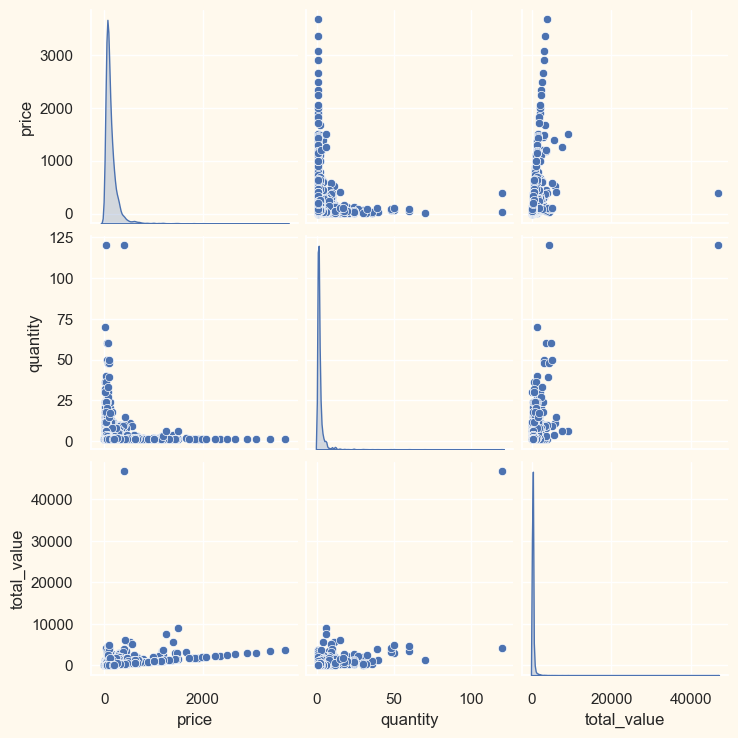

In [13]:
# Pairplot for numerical features
sns.pairplot(data[['price', 'quantity', 'total_value']], diag_kind='kde')
plt.show()

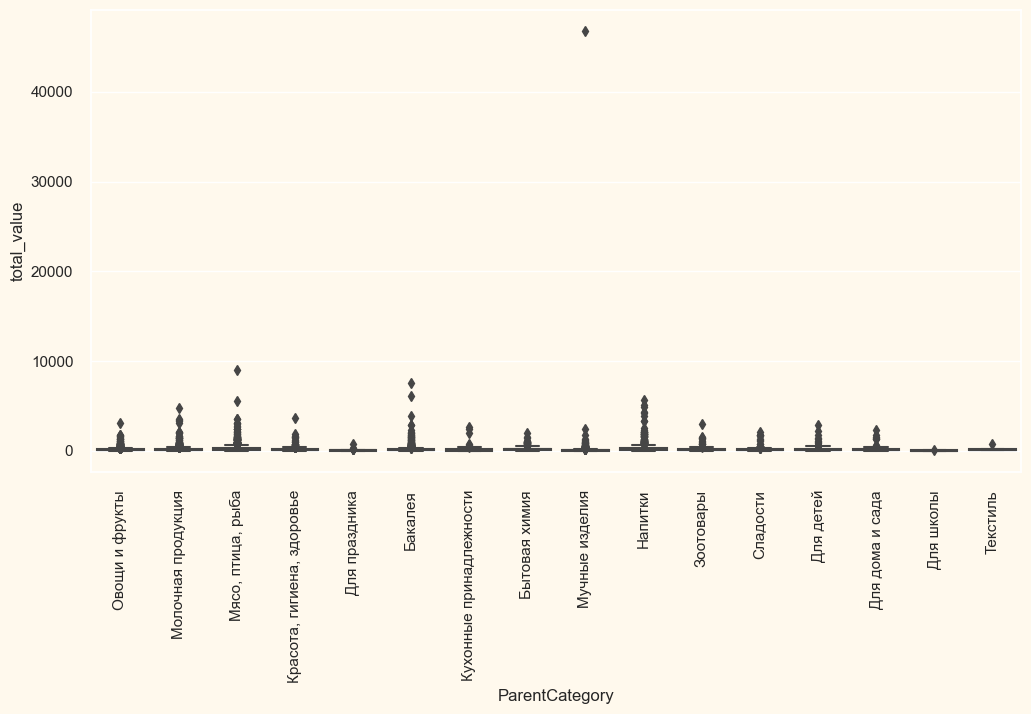

In [14]:
# Boxplot for categorical features
plt.figure(figsize=(12, 6))
sns.boxplot(x='ParentCategory', y='total_value', data=data)
plt.xticks(rotation=90)
plt.show()

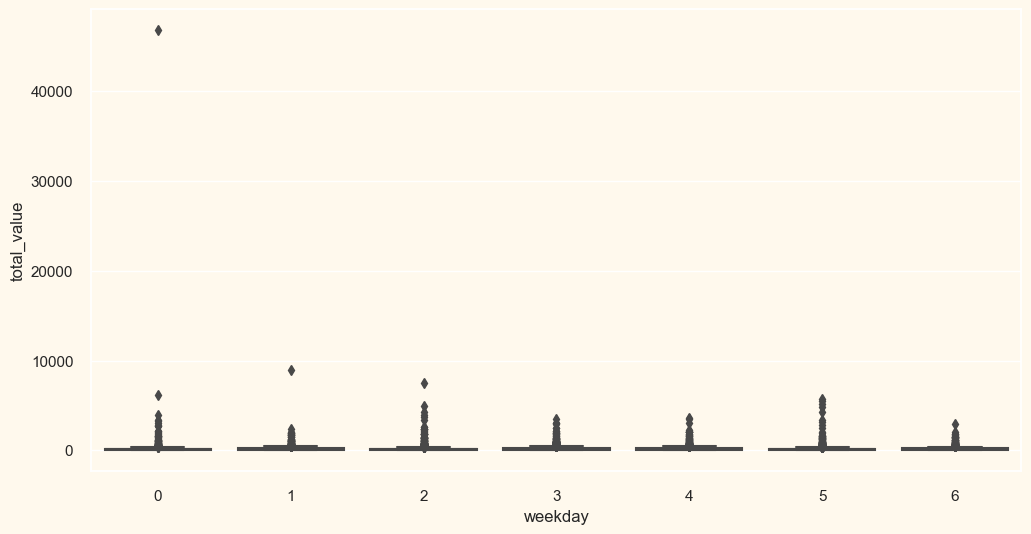

In [15]:
# Boxplot for time features
plt.figure(figsize=(12, 6))
sns.boxplot(x='weekday', y='total_value', data=data)
plt.show()

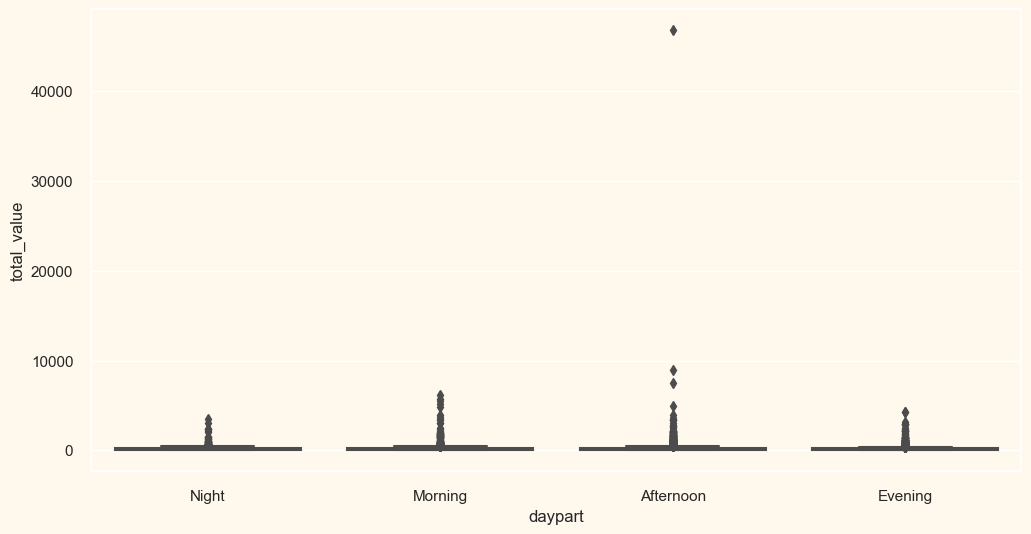

In [16]:
# Boxplot for time features
plt.figure(figsize=(12, 6))
sns.boxplot(x='daypart', y='total_value', data=data)
plt.show()

Relative Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

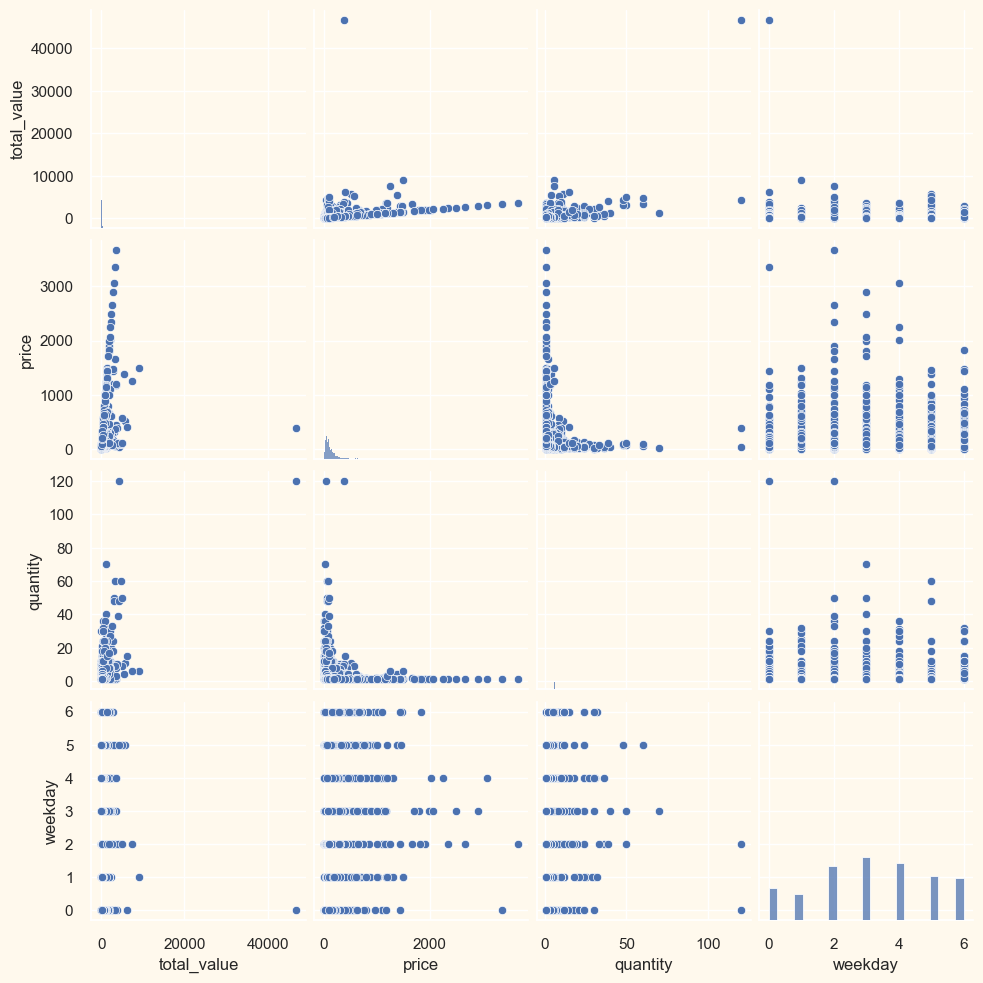

In [18]:
#Plotting following features
To_Plot = ["total_value", "price", "quantity", 'weekday']
print("Relative Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot])
plt.show()

In [19]:
#Let's remove the outliers
data = data[data.total_value < 4000]
data = data[data.quantity < 70]

data['total_value_zscore'] = zscore(data['total_value'])
outlier_threshold = 3
data = data[data['total_value_zscore'].between(-outlier_threshold, 
                                                           outlier_threshold, 
                                                           inclusive='both')]
data = data.drop(columns=['total_value_zscore'])

In [20]:
#Encoding categorical fearutes using LabelEncoder
categoricals = ['daypart', 'Category', 'ParentCategory']

LE=LabelEncoder()
for i in categoricals:
    data[i]=data[[i]].apply(LE.fit_transform)

<Axes: >

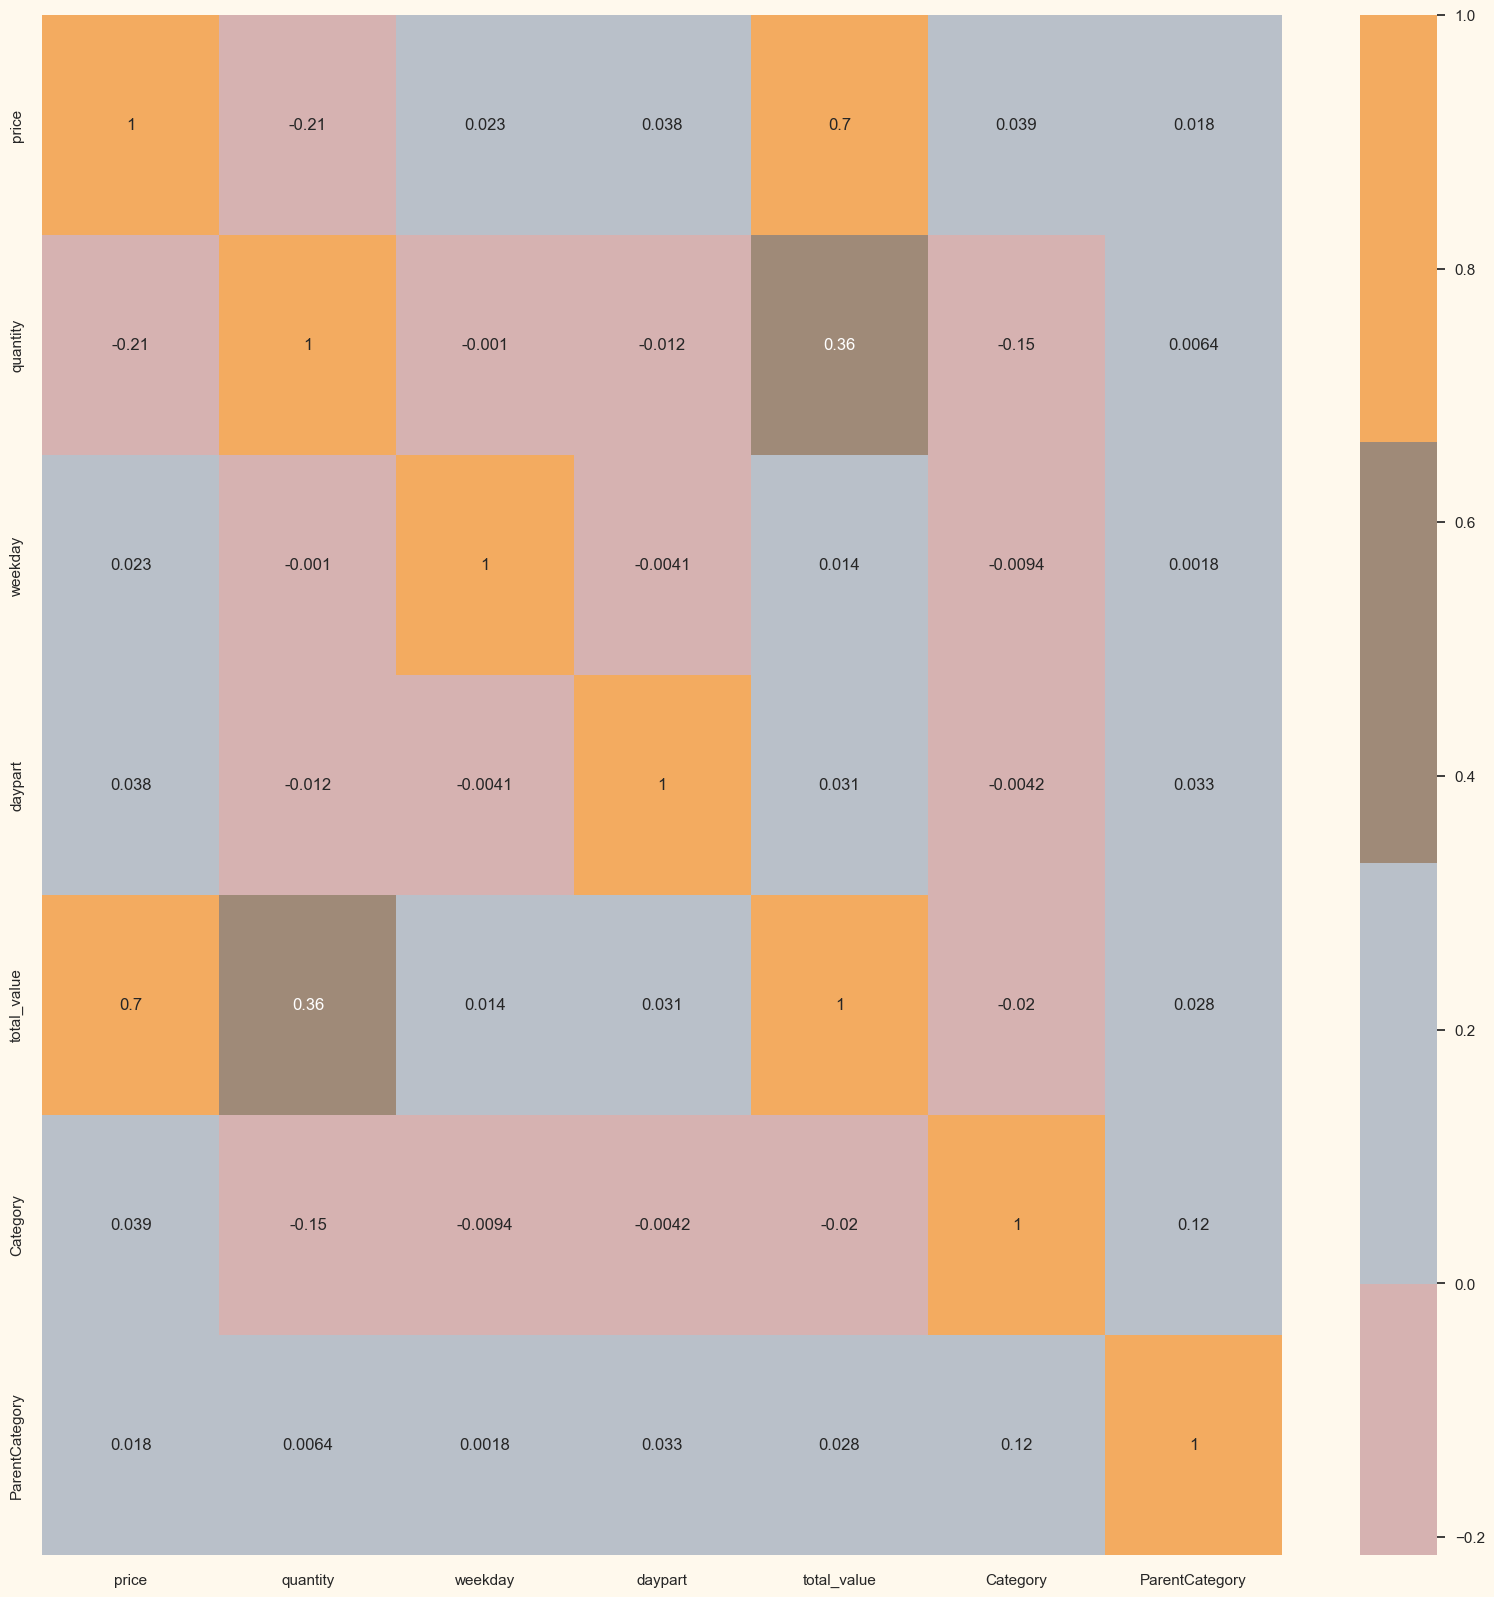

In [21]:
#Building correlation matrix
corrmat= data.drop(columns = ['OrderID', 'UserID', 'ItemID']).corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

In [22]:
# Select relevant features for PCA
features = ['price', 'quantity','total_value', 'daypart', 'Category', 'ParentCategory']

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[features])

In [23]:
# Apply PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame with the PCA results
PCA_ds = pd.DataFrame(data=pca_result, columns=['c1', 'c2', 'c3'])

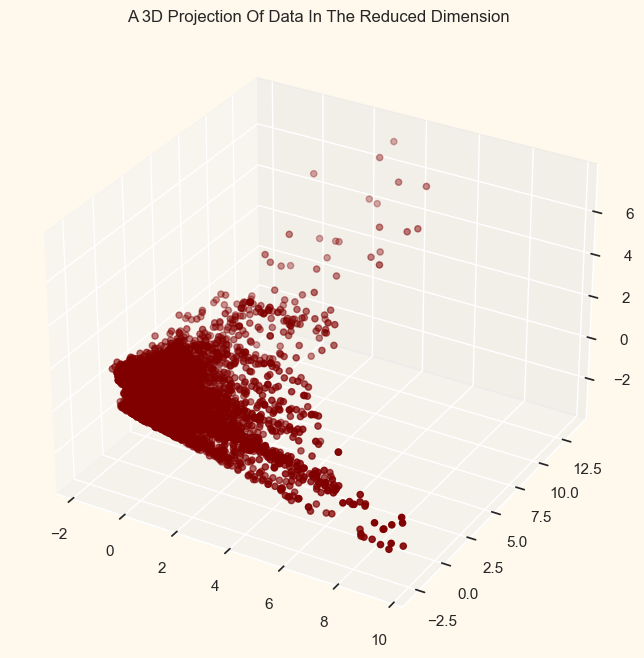

In [24]:
#A 3D Projection Of Data In The Reduced Dimension
x = PCA_ds["c1"]
y = PCA_ds["c2"]
z = PCA_ds["c3"]

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

Elbow Method to determine the number of clusters to be formed:


  File "c:\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


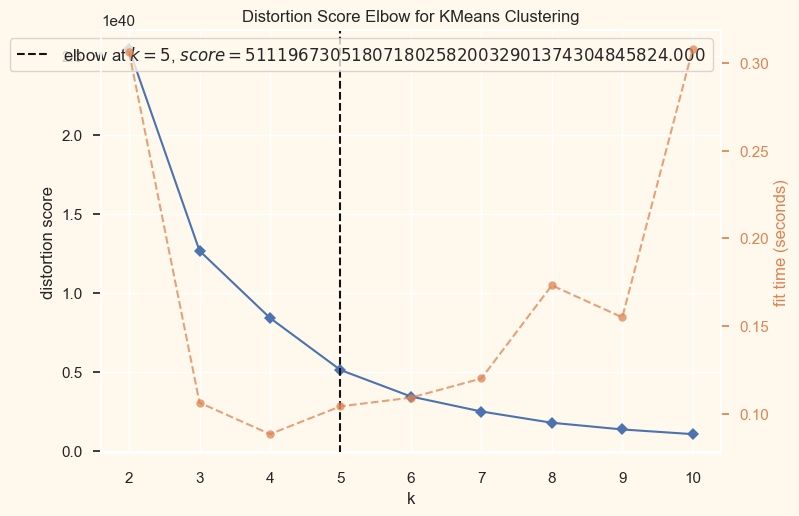

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [25]:
# Quick examination of elbow method to find numbers of clusters to make
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(data)
Elbow_M.show()

In [26]:
#Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=Elbow_M.elbow_value_)
yhat_AC = AC.fit_predict(data)
data["Clusters"]= yhat_AC

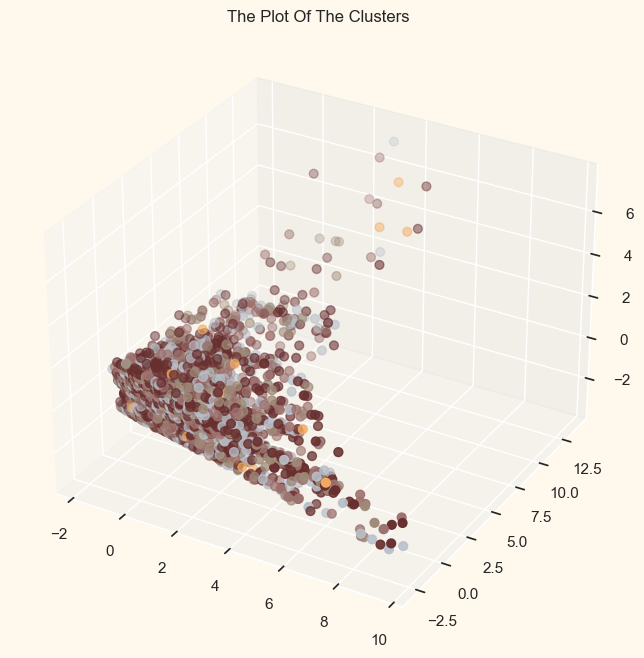

In [27]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=data["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

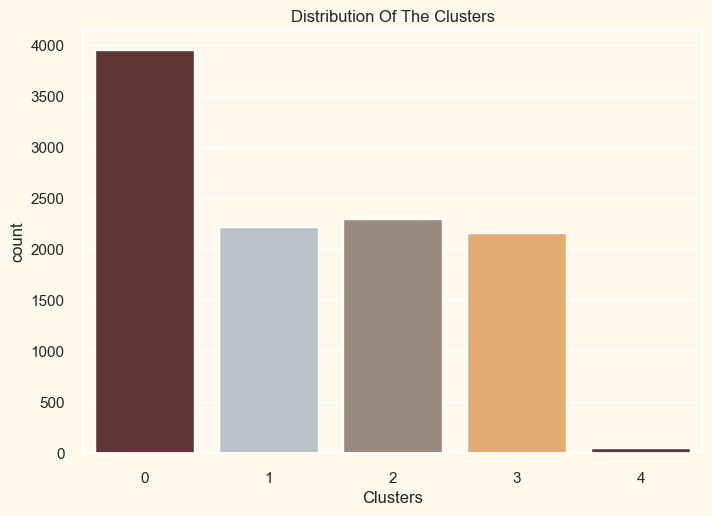

In [28]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


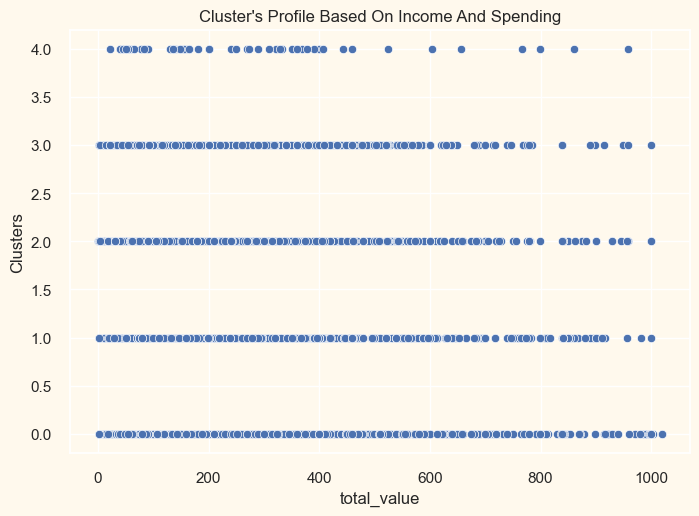

In [29]:
pl = sns.scatterplot(data = data,x=data["total_value"], y=data["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

<Figure size 800x550 with 0 Axes>

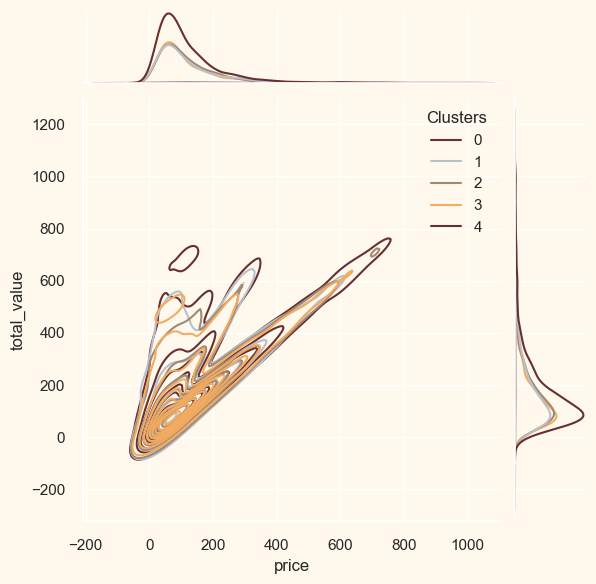

<Figure size 800x550 with 0 Axes>

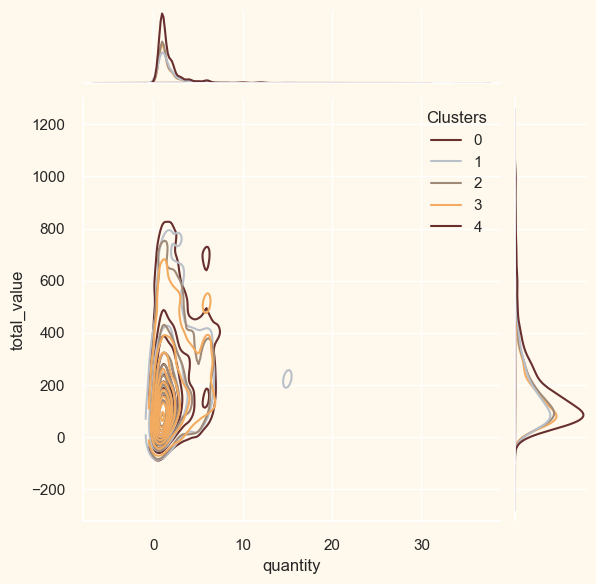

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

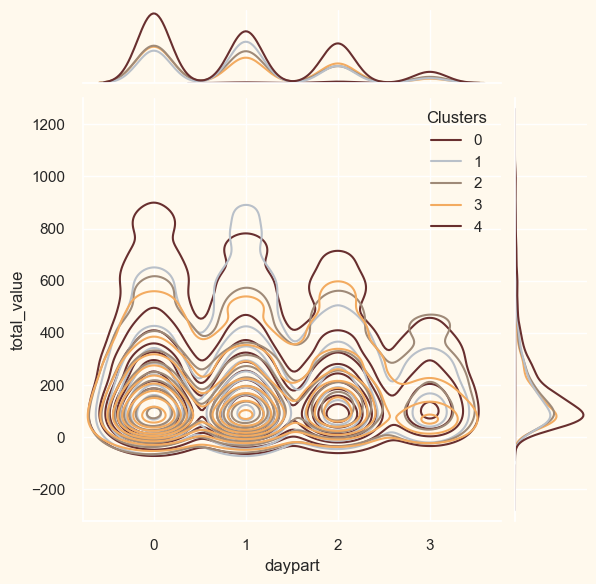

<Figure size 800x550 with 0 Axes>

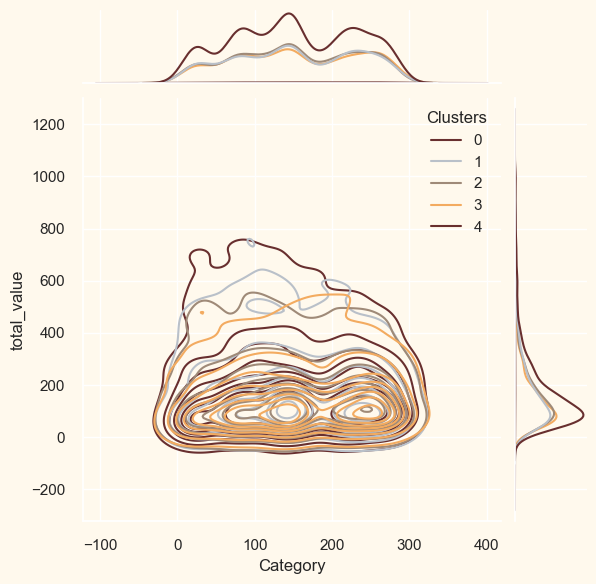

<Figure size 800x550 with 0 Axes>

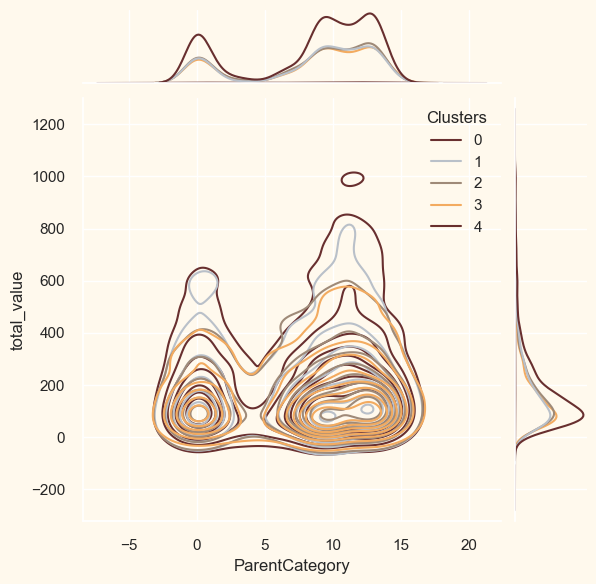

In [31]:
for i in features:
    plt.figure()
    if i != 'total_value':
        sns.jointplot(x=data[i], 
                      y=data["total_value"], 
                      hue =data["Clusters"], 
                      kind="kde", 
                      palette=pal)
    plt.show()